<a href="https://colab.research.google.com/github/yh08037/ABR-Lab-Homework/blob/master/DogBreed_simple_cnn_double_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classification

## Set Tensorflow 2.0

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Download and inspect dataset

### Retrieve the images

In [3]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2019-08-30 08:33:01--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  25.6MB/s    in 51s     

2019-08-30 08:33:52 (15.0 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2019-08-30 08:33:53--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  6.25MB/s    in 3.3s    

2019-08-30 08:33:57 (6.25 MB/s) - ‘annotat

In [0]:
import tarfile

def tar_open(tarName):
  tar = tarfile.open(tarName)
  tar.extractall()
  tar.close()
    
tar_open("images.tar")
tar_open("annotation.tar")

In [5]:
import pathlib
data_root = pathlib.Path('/content/Images')
print(data_root)

/content/Images


In [6]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

image_count = len(all_image_paths)
image_count

20580

In [7]:
all_image_paths[:10]

['/content/Images/n02089078-black-and-tan_coonhound/n02089078_3869.jpg',
 '/content/Images/n02089078-black-and-tan_coonhound/n02089078_1842.jpg',
 '/content/Images/n02089078-black-and-tan_coonhound/n02089078_877.jpg',
 '/content/Images/n02089078-black-and-tan_coonhound/n02089078_1472.jpg',
 '/content/Images/n02089078-black-and-tan_coonhound/n02089078_2753.jpg',
 '/content/Images/n02089078-black-and-tan_coonhound/n02089078_3648.jpg',
 '/content/Images/n02089078-black-and-tan_coonhound/n02089078_456.jpg',
 '/content/Images/n02089078-black-and-tan_coonhound/n02089078_243.jpg',
 '/content/Images/n02089078-black-and-tan_coonhound/n02089078_324.jpg',
 '/content/Images/n02089078-black-and-tan_coonhound/n02089078_4024.jpg']

### Crop images with annotation

In [0]:
import re
import os
from PIL import Image

cropped_data_root = '/content/Cropped'

if not os.path.exists(cropped_data_root):
  os.mkdir(cropped_data_root) 

for path in all_image_paths:
  label = pathlib.Path(path).parent.name
  if not os.path.exists(cropped_data_root + '/' + label):
    os.mkdir(cropped_data_root + '/' + label)
  
  anno_path = path.replace('Images', 'Annotation')
  anno_path = anno_path.replace('.jpg', '')
  
  with open(anno_path, 'r') as f:
    while True:
      line = f.readline()
      if not line: break

      line = re.sub('[\t<>]', '', line)
      if 'xmin' in line: xmin = int(re.sub('[/a-zA-Z]', '', line))
      if 'ymin' in line: ymin = int(re.sub('[/a-zA-Z]', '', line))
      if 'xmax' in line: xmax = int(re.sub('[/a-zA-Z]', '', line))
      if 'ymax' in line: ymax = int(re.sub('[/a-zA-Z]', '', line))

  im = Image.open(path)
  crop_image = im.crop((xmin, ymin, xmax, ymax)).convert('RGB')
  if not os.path.exists(path.replace('Images', 'Cropped')):
    crop_image.save(path.replace('Images', 'Cropped'))

In [9]:
all_cropped_paths = list(pathlib.Path(cropped_data_root).glob('*/*'))
all_cropped_paths = [str(path) for path in all_cropped_paths]
random.shuffle(all_cropped_paths)

cropped_count = len(all_cropped_paths)
cropped_count

20580

### Inspect the images

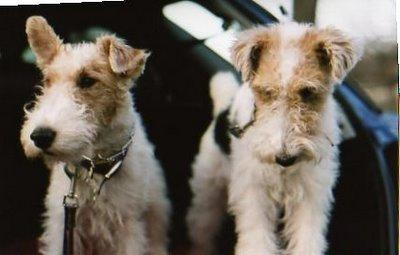

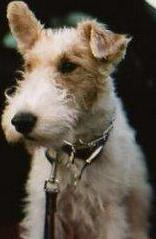

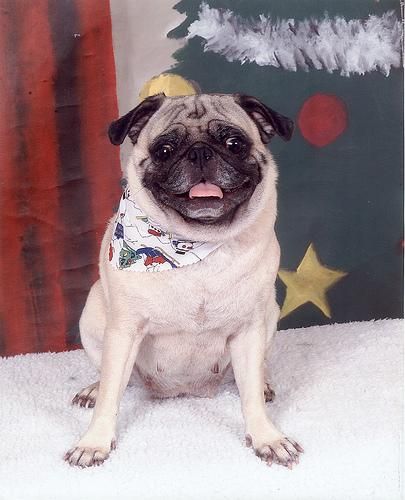

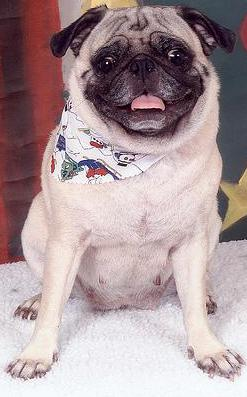

In [10]:
import IPython.display as display

for n in range(2):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    display.display(display.Image(image_path.replace('Images', 'Cropped')))
    print()

In [11]:
import gc
gc.collect()

163

In [0]:
del all_image_paths

## Determines the label for each image

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))

In [14]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_cropped_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [52, 66, 34, 82, 112, 99, 29, 76, 48, 76]


## Load and format the images

In [0]:
import re

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [128, 128])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

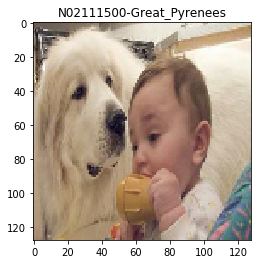

In [17]:
import matplotlib.pyplot as plt

random_index = random.choice(range(image_count))

image_path = all_cropped_paths[random_index]
label = all_image_labels[random_index]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

## A dataset of ```(image, label)``` pairs

In [0]:
valid_ratio = 0.1
test_ratio = 0.1

num_valid = int(cropped_count * valid_ratio)
num_test = int(cropped_count * test_ratio)
num_train = cropped_count - num_valid - num_test

train_paths = all_cropped_paths[ : num_train]
train_labels = all_image_labels[ : num_train]

valid_paths = all_cropped_paths[num_train : -num_test]
valid_labels = all_image_labels[num_train : -num_test]

test_paths = all_cropped_paths[-num_test : ]
test_labels = all_image_labels[-num_test : ]

In [19]:
len(train_paths), len(valid_paths), len(test_paths)

(16464, 2058, 2058)

In [0]:
ds_train = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
ds_valid = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
ds_test = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

ds_train = ds_train.map(load_and_preprocess_from_path_label)
ds_valid = ds_valid.map(load_and_preprocess_from_path_label)
ds_test = ds_test.map(load_and_preprocess_from_path_label)

## Basic methods for training
* To be well shuffled
* To be batched
* To repeat forever
* Batched to be available as soon as possible


In [21]:
BATCH_SIZE=100

# ds_train = ds_train.cache() # cache
ds_train = ds_train.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=num_train))
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_train

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

In [22]:
ds_valid = ds_valid.batch(BATCH_SIZE)
ds_valid

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

In [23]:
ds_test = ds_test.batch(BATCH_SIZE)
ds_test

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

In [24]:
gc.collect()

2275

## Pipe the dataset to a model

In [33]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(128, 128, 3), name='img')
x = layers.Conv2D(96, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(192, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(384, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(768, 3, activation='relu', padding='same')(x)
x = layers.Flatten()(x)

x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(120, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='cnn_3_2')
model.summary()

Model: "cnn_3_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 96)      2688      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 42, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 192)       166080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 192)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 384)       663936    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 384)         0   

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [35]:
len(model.trainable_variables)

12

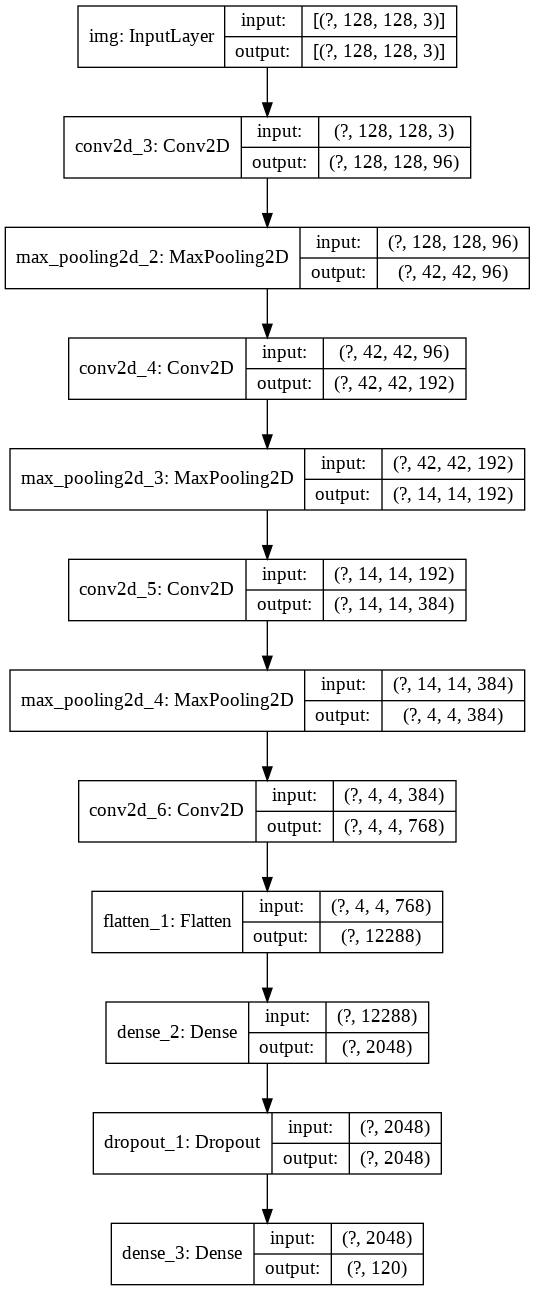

In [36]:
keras.utils.plot_model(model, 'cnn_3_2.png', show_shapes=True)

In [37]:
model.summary()

Model: "cnn_3_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 96)      2688      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 42, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 192)       166080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 192)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 384)       663936    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 384)         0   

In [38]:
steps_per_epoch=tf.math.ceil(num_train/BATCH_SIZE).numpy()
steps_per_epoch

165.0

In [39]:
model.fit(ds_train, epochs=10, steps_per_epoch=steps_per_epoch, validation_data = ds_valid)

Train for 165.0 steps, validate for 21 steps
Epoch 1/10
165/165 [==============================] - 41s 251ms/step - loss: 4.7721 - accuracy: 0.0119 - val_loss: 4.6826 - val_accuracy: 0.0219
Epoch 2/10
165/165 [==============================] - 24s 145ms/step - loss: 4.4115 - accuracy: 0.0356 - val_loss: 4.1392 - val_accuracy: 0.0603
Epoch 3/10
165/165 [==============================] - 24s 146ms/step - loss: 4.0601 - accuracy: 0.0652 - val_loss: 3.8919 - val_accuracy: 0.0841
Epoch 4/10
165/165 [==============================] - 24s 146ms/step - loss: 3.8083 - accuracy: 0.0979 - val_loss: 3.6869 - val_accuracy: 0.1283
Epoch 5/10
165/165 [==============================] - 24s 143ms/step - loss: 3.5889 - accuracy: 0.1391 - val_loss: 3.5890 - val_accuracy: 0.1433
Epoch 6/10
165/165 [==============================] - 23s 139ms/step - loss: 3.3137 - accuracy: 0.1851 - val_loss: 3.3432 - val_accuracy: 0.1793
Epoch 7/10
165/165 [==============================] - 23s 139ms/step - loss: 3.0466 -

In [41]:
model.fit(ds_train, epochs=10, steps_per_epoch=steps_per_epoch, validation_data = ds_valid)

Train for 165.0 steps, validate for 21 steps
Epoch 1/10
165/165 [==============================] - 63s 383ms/step - loss: 1.7433 - accuracy: 0.5156 - val_loss: 3.3616 - val_accuracy: 0.2371
Epoch 2/10
165/165 [==============================] - 25s 150ms/step - loss: 1.4000 - accuracy: 0.6084 - val_loss: 3.5232 - val_accuracy: 0.2502
Epoch 3/10
165/165 [==============================] - 24s 148ms/step - loss: 1.1189 - accuracy: 0.6781 - val_loss: 3.8757 - val_accuracy: 0.2371
Epoch 4/10
165/165 [==============================] - 24s 146ms/step - loss: 0.8493 - accuracy: 0.7496 - val_loss: 4.0674 - val_accuracy: 0.2342
Epoch 5/10
165/165 [==============================] - 23s 138ms/step - loss: 0.6991 - accuracy: 0.7910 - val_loss: 4.4831 - val_accuracy: 0.2313
Epoch 6/10
165/165 [==============================] - 23s 137ms/step - loss: 0.5751 - accuracy: 0.8264 - val_loss: 4.5312 - val_accuracy: 0.2357
Epoch 7/10
165/165 [==============================] - 23s 137ms/step - loss: 0.4491 -

In [42]:
model.evaluate(ds_test)

21/21 [==============================] - 2s 105ms/step - loss: 5.2809 - accuracy: 0.2230


[5.280875433058966, 0.22303207]